# パラメータの初期値を変えながら、2層ニューラルネットワークで単純な回帰問題を解く

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、notebook/commonフォルダのfunctions.py、layers.py、loss.py、optimizer.pyを選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
except:
    print('ローカル環境での実行です')


from common.loss import mean_squared_error
from common.layers import Affine, ReLU,MeanSquaredLoss, LeakyReLU
from common.optimizer import RMSProp, SGD

ローカル環境での実行です


## 2層ニューラルネットワーククラス

In [2]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        
        
#         # (1)パラメータの初期値を全て0にした場合
#         self.params["W1"] = np.zeros((input_size, hidden_size))
#         self.params["b1"] = np.zeros(hidden_size) 
#         self.params["W2"] = np.zeros((hidden_size, output_size))
#         self.params["b2"] = np.zeros(output_size) 

#         # (2)Wの初期値を0にし、bの初期値を1にした場合
#         self.params["W1"] = np.zeros((input_size, hidden_size))
#         self.params["b1"] = np.ones(hidden_size) 
#         self.params["W2"] = np.zeros((hidden_size, output_size))
#         self.params["b2"] = np.ones(output_size) 

#         # (3)パラメータの初期値を全て1にした場合
#         self.params["W1"] = np.ones((input_size, hidden_size))
#         self.params["b1"] = np.ones(hidden_size) 
#         self.params["W2"] = np.ones((hidden_size, output_size))
#         self.params["b2"] = np.ones(output_size) 
        
#         # (4)パラメータの初期値を全て1にし、1つだけ1以外にした場合
#         self.params["W1"] = np.ones((input_size, hidden_size))
#         self.params["b1"] = np.ones(hidden_size) 
#         self.params["W2"] = np.ones((hidden_size, output_size))
#         self.params["b2"] = np.ones(output_size)         
#         self.params["W1"][0,2] = 2.0 # 1箇所だけ2にする
        
#         # (5)パラメータの初期値を正規分布にしたがってランダムにサンプリングした場合
#         np.random.seed(1111)
#         self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
#         np.random.seed(1112)
#         self.params["b1"] = weight_init_std * np.random.randn(hidden_size)
#         np.random.seed(1113)
#         self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
#         np.random.seed(1114)
#         self.params["b2"] = weight_init_std * np.random.randn(output_size)
        
        # (6)Wの初期値を正規分布にしたがってランダムにサンプリングし、bの初期値を0にした場合
        np.random.seed(2222)        
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        np.random.seed(2223)        
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size) 
        self.params['b2'] = np.zeros(output_size)
        
        
        # レイヤの生成
        self.layers = OrderedDict() # 順番付きdict形式.
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] =  ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = MeanSquaredLoss() # 出力層
        
    def predict(self, x):
        """
        予測関数
        x : 入力
        """
        for layer in self.layers.values():
            # 入力されたxを更新していく = 順伝播計算
            x = layer.forward(x)
        
        return x
        
    def loss(self, x, t):
        """
        損失関数
        x:入力データ, t:教師データ
        """
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        """
        精度
        """
        y = self.predict(x)
        return mean_squared_error(y, t)

        
    def gradient(self, x, t):
        """
        全パラメータの勾配を計算
        """
        
        # 順伝播
        self.loss(x, t)

        # 逆伝播
        dout = self.lastLayer.backward(dout=1) # 出力層
        
        ## doutを逆向きに伝える 
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # dW, dbをgradsにまとめる
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db    

        return grads
    

## データの生成

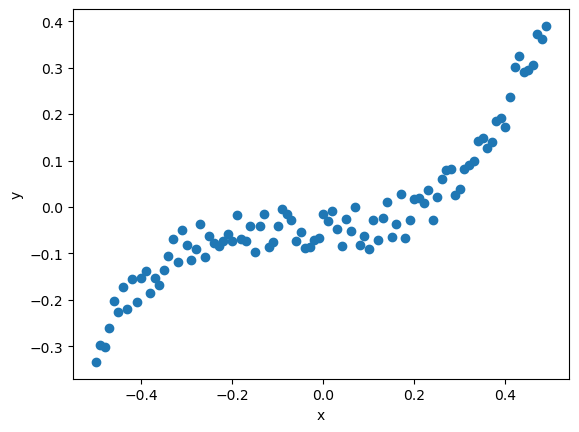

In [3]:
a = 3
b = 0.5
c = -0.1
x = np.arange(-0.5, 0.5, 0.01)
error = np.random.rand(x.size) * 0.1
y = a * x**3 + b * x**2 + c + error
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ミニバッチ学習

In [4]:
x = x.reshape(-1, 1)
t = y.reshape(-1, 1)

ecpochs = 5000
batch_size = 25
lr = 0.01

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# 2層NNのオブジェクト生成
tnet = TwoLayerNet(input_size=1, hidden_size=10, output_size=1, weight_init_std=0.01)

# 最適化手法
optimizer = RMSProp(lr=lr, rho=0.9)
    
# 初期パラメータの確認
print("初期パラメータ")
print(tnet.params["W1"].round(4))
print(tnet.params["b1"].round(4))
print(tnet.params["W2"].round(4))
print(tnet.params["b2"].round(4))


li_loss = []
for epoch in range(ecpochs):
    
    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        mask = idx[batch_size*it : batch_size*(it+1)]
    
        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]
        
        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = tnet.gradient(x_train, t_train)

        # パラメータの更新
        optimizer.update(tnet.params, grads)

    # 学習経過の記録
    loss = tnet.loss(x, t)
    li_loss.append(loss)

/tmp/ipykernel_4697/1818650273.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iter_num = np.ceil(xsize / batch_size).astype(np.int)


初期パラメータ
[[-0.0094  0.0101  0.0046  0.0072  0.0055 -0.0123 -0.0011 -0.0044  0.0114
   0.0061]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[ 0.0144]
 [ 0.0135]
 [-0.003 ]
 [-0.0099]
 [ 0.0159]
 [ 0.0065]
 [ 0.0008]
 [ 0.0045]
 [ 0.0104]
 [-0.0104]]
[0.]


### 学習結果の確認

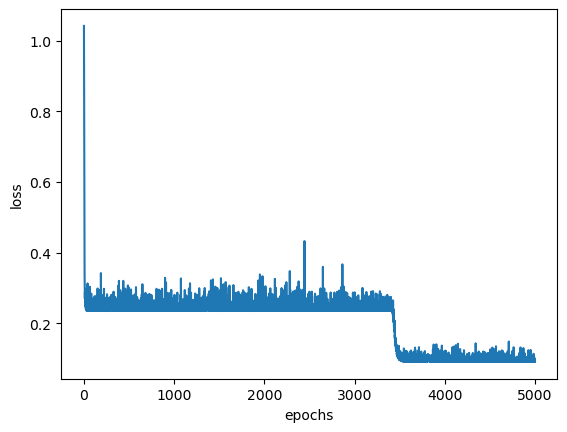

In [5]:
# lossのグラフ化
pd.DataFrame(li_loss).plot(legend=False)
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

mse= 0.0009102033974884461


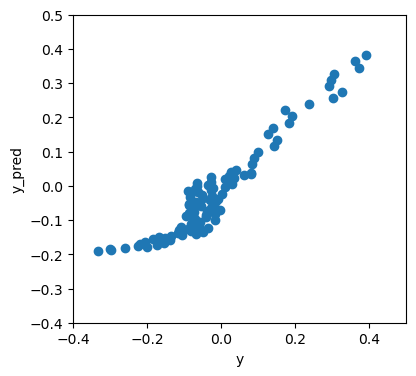

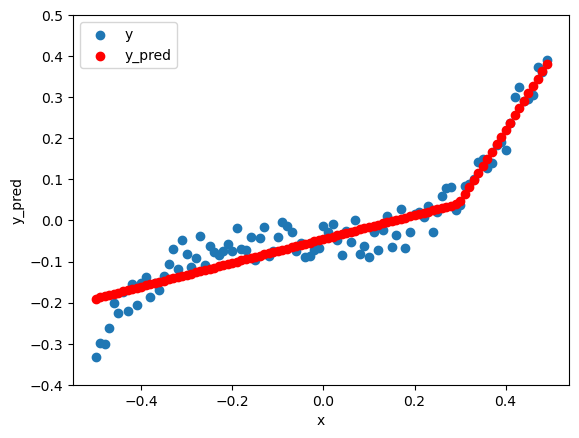

In [6]:
# 訓練精度の確認
y_pred = tnet.predict(x)
print("mse=",mean_squared_error(y_pred, t))

# 学習データと予測データの比較1
plt.figure(figsize=(4.3,4))
plt.scatter(y, y_pred)
plt.xlabel("y")
plt.ylabel("y_pred")
plt.xlim([-0.4,0.5])
plt.ylim([-0.4,0.5])
plt.show()

# 学習データと予測データの比較2
plt.scatter(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(x, y_pred, c="r")
plt.xlabel("x")
plt.ylabel("y_pred")
plt.legend(["y","y_pred"])
plt.ylim([-0.4,0.5])
plt.show()

### パラメータの分布の確認

In [7]:
# 最終パラメータの確認
print(tnet.params["W1"].round(4))
print(tnet.params["b1"].round(4))
print(tnet.params["W2"].round(4))
print(tnet.params["b2"].round(4))

[[-7.5000e-03  7.4810e-01  3.7000e-03  5.2000e-03  3.6940e-01 -1.0000e-02
  -9.0000e-04 -3.3000e-03  1.3575e+00  4.1000e-03]]
[-0.0056  0.3831 -0.002  -0.0035 -0.1411 -0.0058 -0.0006 -0.0026 -0.4023
 -0.0037]
[[ 1.3100e-02]
 [ 3.8790e-01]
 [-2.0000e-03]
 [-8.5000e-03]
 [ 1.6660e-01]
 [ 4.0000e-03]
 [ 7.0000e-04]
 [ 3.9000e-03]
 [ 1.0554e+00]
 [-9.2000e-03]]
[-0.1937]


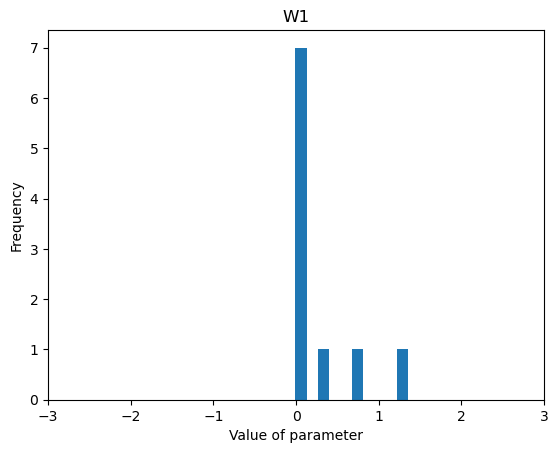

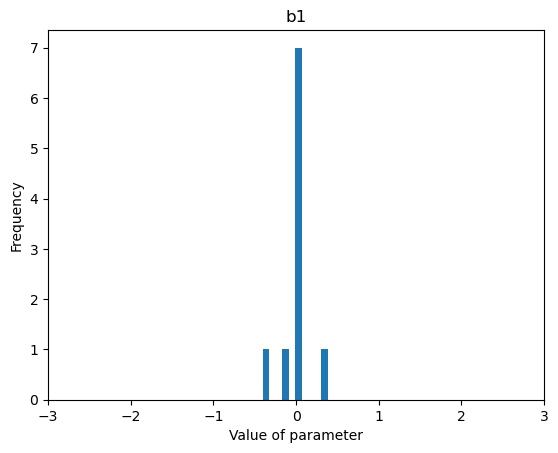

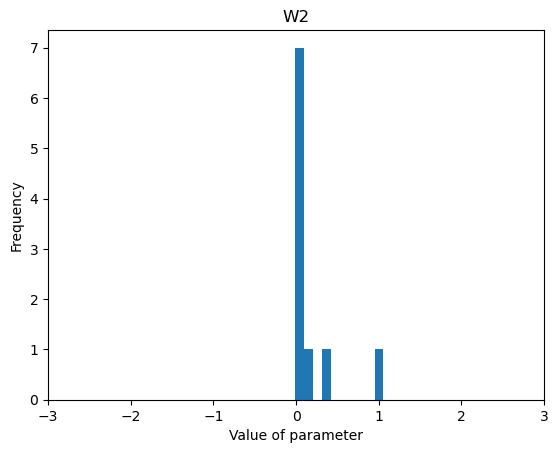

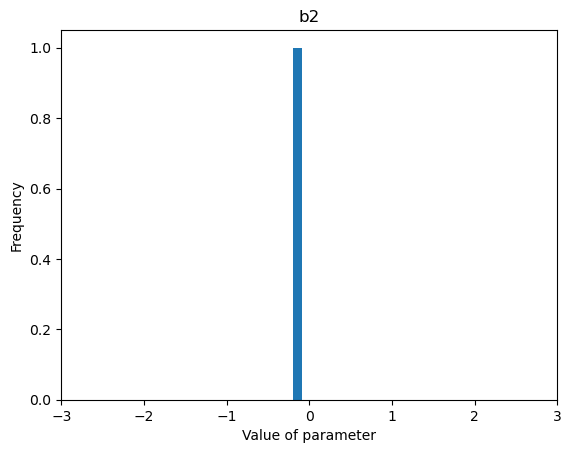

In [8]:
# パラメータ分布
for key, value in tnet.params.items():
    plt.hist(value.flatten(), bins=10)
    plt.title(key)
    plt.xlim([-3, 3])
    plt.ylabel("Frequency")
    plt.xlabel("Value of parameter")
    plt.show()

### [演習]
* パラメータの初期値を以下のように設定し、結果を比較してみましょう
#### (1)パラメータの初期値を全て0にした場合
#### (2)Wの初期値を0にし、bの初期値を1にした場合
#### (3)パラメータの初期値を全て1にした場合
#### (4)パラメータの初期値を全て1にし、1つだけ1以外にした場合
#### (5)パラメータの初期値を正規分布にしたがってランダムにサンプリングした場合
#### (6)Wの初期値を正規分布にしたがってランダムにサンプリングし、bの初期値を0にした場合


### [計算結果]

#### (1)パラメータの初期値を全て0にした場合
* 学習結果のパラメータをみると、同じ層内でばらついていないことがわかる

#### (2)Wの初期値を0にし、bの初期値を1にした場合
* 学習結果のパラメータをみると、同じ層内でばらついていないことがわかる

#### (3)パラメータの初期値を全て1にした場合
* 学習結果のパラメータをみると、同じ層内でばらついていないことがわかる

#### (4)パラメータの初期値を全て1にし、1つだけ1以外にした場合
* パラメータの初期値を全て同じ値にする時に比べ、学習結果のパラメータにばらつきが生じているが、そのばらつきは極めて小さい

#### (5)パラメータの初期値を正規分布にしたがってランダムにサンプリングした場合
* パラメータの初期値を全て同じ値にする時に比べ、学習結果のパラメータにばらつきが生じている
* 学習結果におけるバイアスの値は、0付近である

#### (6)Wの初期値を正規分布にしたがってランダムにサンプリングし、bの初期値を0にした場合
* パラメータの初期値を全て同じ値にする時に比べ、学習結果のパラメータにばらつきが生じている
* 学習結果におけるバイアスの値は、0付近である